## Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yahooquery as yf
import math

## Load Ticker Data

In [3]:
ticker = "SPY"
data = yf.Ticker(ticker)

## Stock Data Exploration

In [4]:
df = data.history(start='2020-01-01').reset_index()
df.head()

,symbol,date,open,high,low,close,volume,adjclose,dividends
0,SPY,2020-01-02,323.540009,324.890015,322.529999,324.869995,59151200,298.578644,0.0
1,SPY,2020-01-03,321.160004,323.640015,321.100006,322.410004,77709700,296.317780,0.0
2,SPY,2020-01-06,320.489990,323.730011,320.359985,323.640015,55653900,297.448273,0.0
3,SPY,2020-01-07,323.019989,323.540009,322.239990,322.730011,40496400,296.611816,0.0
4,SPY,2020-01-08,322.940002,325.779999,322.670013,324.450012,68296000,298.192627,0.0


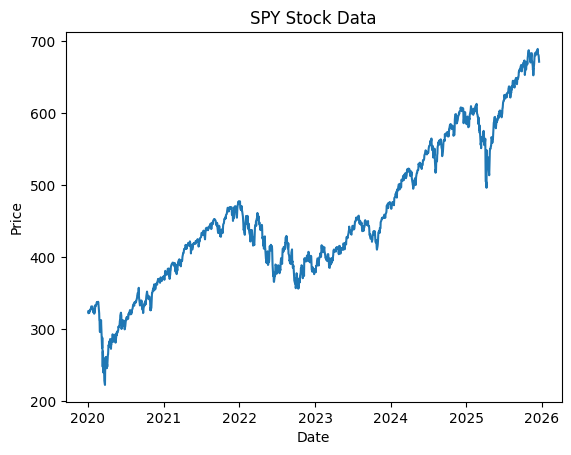

In [5]:
x = df['date']
y = df['close']
plt.plot(x, y)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Data')
plt.show()

## Daily Changes Exploration

In [6]:
diffs = []
for i in range(1, df.shape[0]):
    p1 = df['close'].iloc[i-1]
    p2 = df['close'].iloc[i]
    diff = round(((p2 - p1) / p2) * 100, 5)
    diffs.append(diff)


In [7]:
dff = pd.DataFrame(data=diffs, columns=["daily_change"])
stats=dff.describe()
stats

,daily_change
count,1498.000000
mean,0.039758
std,1.322625
min,-12.286850
25%,-0.500363
50%,0.093140
75%,0.680915
max,9.503840


In [8]:
std = stats.loc['std', 'daily_change']
mean = stats.loc['mean', 'daily_change']

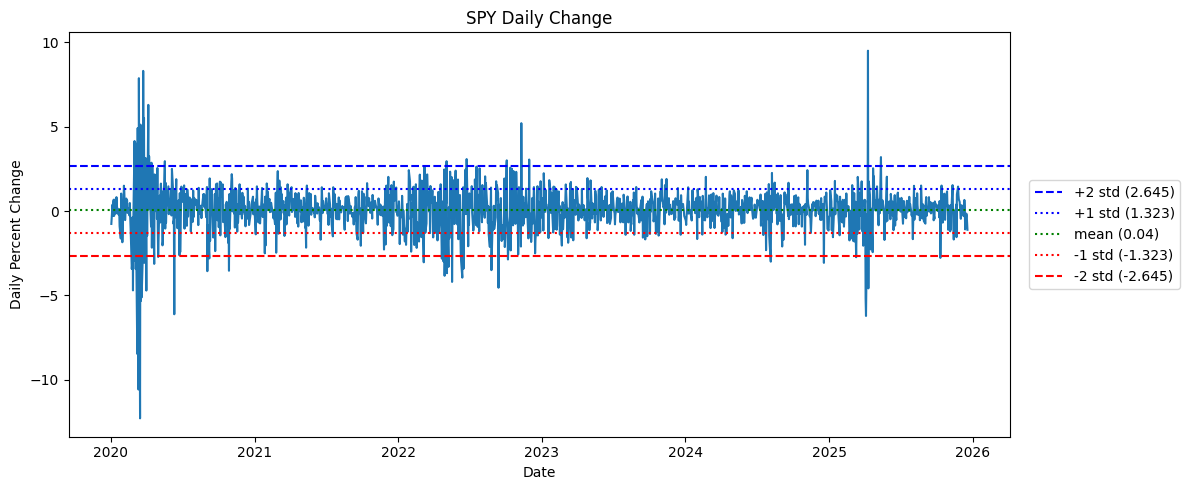

In [9]:
x = df['date'].iloc[1:]
y = dff['daily_change']

plt.figure(figsize=(12,5))
plt.plot(x, y)

# Daily price change standard deviations
plt.axhline(y = 2*std, color = 'b', linestyle = '--', label = f'+2 std ({round(2*std, 3)})')
plt.axhline(y = 1*std, color = 'b', linestyle = 'dotted', label = f'+1 std ({round(1*std, 3)})')
plt.axhline(y = mean, color = 'g', linestyle = 'dotted', label = f'mean ({round(mean, 3)})')
plt.axhline(y = -1*std, color = 'r', linestyle = 'dotted', label = f'-1 std ({round(-1*std, 3)})')
plt.axhline(y = -2*std, color = 'r', linestyle = '--', label = f'-2 std ({round(-2*std, 3)})')

plt.xlabel('Date')
plt.ylabel('Daily Percent Change')
plt.title(f'{ticker} Daily Change')
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0.)
plt.tight_layout()
plt.show()

<Axes: ylabel='Count'>

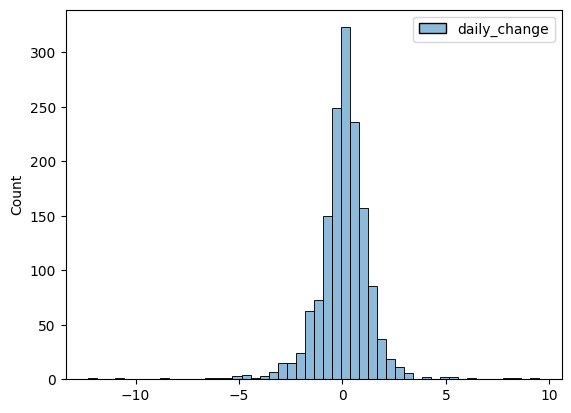

In [10]:
sns.histplot(data=dff, bins=50)

<Axes: >

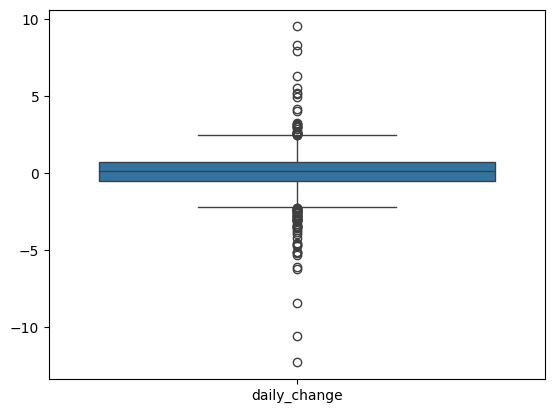

In [11]:
sns.boxplot(data = dff)

## Next Day Table

In [12]:
def round_by_5(num, base=5):
    if num >= 0:
        return base * math.ceil(num/base)
    else:
        return base * math.floor(num/base)

In [13]:
maxi = max(dff['daily_change'])
mini = min(dff['daily_change'])

print(f'({mini}, {maxi})')

maxi_rounded = round_by_5(max(dff['daily_change']))
mini_rounded = round_by_5(min(dff['daily_change']))

print(f'({mini_rounded}, {maxi_rounded})')

(-12.28685, 9.50384)
(-15, 10)


In [14]:
bins = np.array(range(mini_rounded, maxi_rounded+1, 5))
table = np.zeros((len(bins), len(bins)))

for i in range(len(diffs) - 1):
    today = 0
    for j in range(0, len(bins)):
        if diffs[i] <= bins[j]:
            today = j
            break
    
    tomorrow = 0
    for j in range(1, len(bins)):
        if diffs[i+1] <= bins[j]:
            tomorrow = j
            break
    
    table[today][tomorrow] += 1

change_counts_df = pd.DataFrame(table, columns=bins, index=bins)

print(f'Range of daily percent changes: ({mini}, {maxi})')
print("Next Day Change")
change_counts_df.style.background_gradient(cmap='Blues', axis=None)

Range of daily percent changes: (-12.28685, 9.50384)
Next Day Change


,-15,-10,-5,0,5,10
-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-10,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
-5,0.000000,1.000000,1.000000,2.000000,3.000000,0.000000
0,0.000000,0.000000,2.000000,287.000000,371.000000,4.000000
5,0.000000,0.000000,3.000000,373.000000,440.000000,1.000000
10,0.000000,1.000000,1.000000,2.000000,3.000000,0.000000


The highest count (440) shows that after a day of 0% - 5% increase, we see another 0% - 5% increase.

## Buy Close Sell Open (BCSO) vs Buy OPen Sell Close (BOSC)

In [16]:
def buy(bal, price):
    shares = int((bal//price))
    cost = shares * price
    return shares, cost

In [36]:
# Buy Close Sell Open
def bcso(balance, hist):
    total_pnl = 0
    running_pnl = []

    for i in range(hist.shape[0] - 1):
        close = hist['close'].iloc[i]
        shares, cost = buy(balance, close)
        pos_pnl = shares*hist['open'].iloc[i+1] - cost
        balance += pos_pnl
        total_pnl += pos_pnl
        running_pnl.append(total_pnl)

    return total_pnl, running_pnl

In [37]:
# Buy Open Sell Close
def bosc(balance, hist):
    total_pnl = 0
    running_pnl = []

    for i in range(hist.shape[0] - 1):
        open = hist['open'].iloc[i]
        shares, cost = buy(balance, open)
        pos_pnl = shares*hist['close'].iloc[i] - cost
        balance += pos_pnl
        total_pnl += pos_pnl
        running_pnl.append(total_pnl)

    return total_pnl, running_pnl

In [38]:
# Buy and Hold
def buy_and_hold(balance, hist):
    total_pnl = 0
    running_pnl = []

    buy_open = hist['open'].iloc[0]
    shares, cost = buy(balance, buy_open)

    for i in range(hist.shape[0] - 1):
        close = hist['close'].iloc[i]
        total_pnl = shares*close - cost
        running_pnl.append(total_pnl)

    return total_pnl, running_pnl

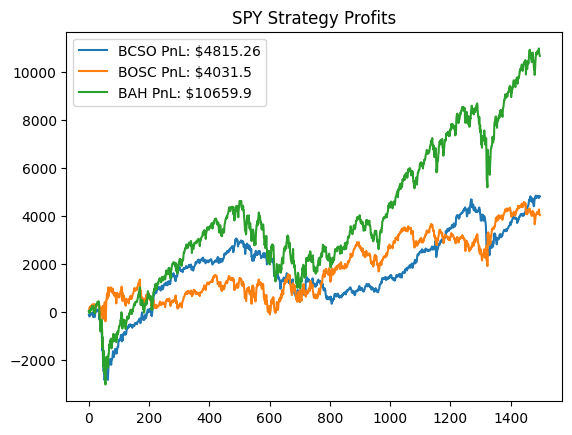

In [60]:
ticker = 'SPY'
start = '2020-01-01'
history = yf.Ticker(ticker).history(start = start).reset_index()

bcso_pnl, bcso_run_pnl = bcso(10000, history)
bosc_pnl, bosc_run_pnl = bosc(10000, history)
bah_pnl, bah_run_pnl = buy_and_hold(10000, history)

x_bcso = range(len(bcso_run_pnl))
x_bosc = range(len(bosc_run_pnl))
x_bah = range(len(bah_run_pnl))

plt.plot(x_bcso, bcso_run_pnl, label = f'BCSO PnL: ${round(bcso_pnl, 2)}')
plt.plot(x_bosc, bosc_run_pnl, label = f'BOSC PnL: ${round(bosc_pnl, 2)}')
plt.plot(x_bah, bah_run_pnl, label = f'BAH PnL: ${round(bah_pnl, 2)}')

plt.title(f'{ticker} Strategy Profits')
plt.legend()
plt.show()